In [1]:
### Preparing the dataset

import sklearn

from sklearn.datasets import make_circles
n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=47)


In [2]:
### Making a dataframe

import pandas as pd

circles = pd.DataFrame( {"X1":X[:,0],  "X2":X[:,1] , "labels":y } )


circles.head(10)

,X1,X2,labels
0,0.750100,0.329277,1
1,0.421556,-0.631267,1
2,0.387180,0.675677,1
3,0.968575,0.296591,0
4,-0.529314,-0.820368,0
5,-0.585169,0.619087,1
6,0.499984,0.618339,1
7,0.236580,-0.813342,1
8,0.545943,-0.538150,1
9,0.094928,1.013539,0


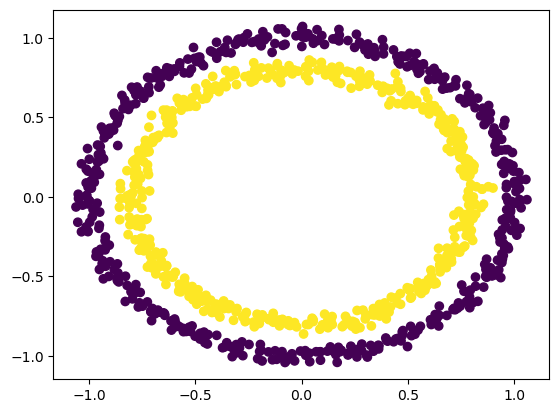

In [3]:
###

import matplotlib.pyplot as plt

plt.scatter(x=X[:,0] , y =X[:,1],c = y)


In [4]:
### Creating test and train splits
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


from sklearn.model_selection  import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=47)


In [5]:
### Model

from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"





class NeuralNetwork(nn.Module):
    
    def __init__(self,input_shape,output_shape=1):
        super().__init__()
        self.layer1 = nn.Linear(input_shape,64)
        self.layer2 = nn.Linear(64,output_shape)
    
    
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer1(x)
        return x
        


model = NeuralNetwork(2).to(device)

#next(model.parameters()).device ## Checking that weights are in the GPU
         

In [6]:
### A simpler representation of the above model

model = nn.Sequential(
    nn.Linear(2,64),
    nn.Linear(64,1),
).to(device)

model

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
class StackedNeuralNetwork(nn.Module):
    
    def __init__(self,input_shape,output_shape=1):
        super().__init__()
        self.layer1 = nn.Linear(input_shape,64)
        self.layer2 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.layer3 = nn.Sequential(
            nn.Linear(32,128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
    
    
    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x=  self.relu(x)
        x = self.layer3(x)
        
        return x
        


model = StackedNeuralNetwork(2).to(device)


In [8]:
### Making predictions


initial_preds = model(X_test.to(device))
print(initial_preds[:10,:])

tensor([[-0.0434],
        [-0.0369],
        [-0.0272],
        [-0.0366],
        [-0.0117],
        [-0.0386],
        [-0.0413],
        [-0.0438],
        [-0.0134],
        [-0.0333]], device='cuda:0', grad_fn=<SliceBackward0>)


In [9]:
from torch import optim

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)



In [19]:
## Accuracy calculation function
def accuracy_calc(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    accuracy = (correct/len(y_pred))*100
    return accuracy




In [11]:
## Evaluating

model.eval()
with torch.inference_mode():
    y_logits = model(X_test.to(device))[:5]

y_logits
y_probs = torch.sigmoid(y_logits)
y_pred_labels = torch.round(y_probs)
y_pred_labels

print(torch.eq(y_test[:5].to(device).squeeze(),y_pred_labels.squeeze()))


tensor([True, True, True, True, True], device='cuda:0')


In [12]:


torch.manual_seed(47)
torch.cuda.manual_seed(47)

epochs = 1000

X_train , X_test , y_train , y_test = X_train.to(device) , X_test.to(device) , y_train.to(device) , y_test.to(device)



for epoch in range(epochs):
    
    model.train()
    
    y_logits = model(X_train).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_labels = torch.round(y_probs)

    loss = criterion(y_logits,y_train)
    acc = accuracy_calc(y_train,y_labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_labels = torch.round(torch.sigmoid(test_logits))
        test_loss = criterion(test_logits,y_test)
        test_acc = accuracy_calc(y_test,test_labels)
    
    
    if(epoch%10==0):
            print(f" Epoch {epoch} \n Training Accuracy ==> {acc} ,  Training Loss ==> {loss}\n Testing Accuracy ==> {test_acc} , Testing Loss ==> {test_loss}  ")
    


 Epoch 0 
 Training Accuracy ==> 49.75 ,  Training Loss ==> 0.6936289072036743
 Testing Accuracy ==> 51.0 , Testing Loss ==> 0.6934493780136108  
 Epoch 10 
 Training Accuracy ==> 46.25 ,  Training Loss ==> 0.6925352215766907
 Testing Accuracy ==> 46.5 , Testing Loss ==> 0.6930406093597412  
 Epoch 20 
 Training Accuracy ==> 52.625 ,  Training Loss ==> 0.6915826201438904
 Testing Accuracy ==> 45.5 , Testing Loss ==> 0.6926760673522949  
 Epoch 30 
 Training Accuracy ==> 53.75 ,  Training Loss ==> 0.690784215927124
 Testing Accuracy ==> 45.0 , Testing Loss ==> 0.6923874020576477  
 Epoch 40 
 Training Accuracy ==> 56.875 ,  Training Loss ==> 0.6900376677513123
 Testing Accuracy ==> 50.5 , Testing Loss ==> 0.6921113729476929  
 Epoch 50 
 Training Accuracy ==> 56.375 ,  Training Loss ==> 0.6892602443695068
 Testing Accuracy ==> 51.5 , Testing Loss ==> 0.6918144226074219  
 Epoch 60 
 Training Accuracy ==> 56.00000000000001 ,  Training Loss ==> 0.6885316371917725
 Testing Accuracy ==> 51.

Helper functions exists. Skipping download
torch.Size([800, 2])


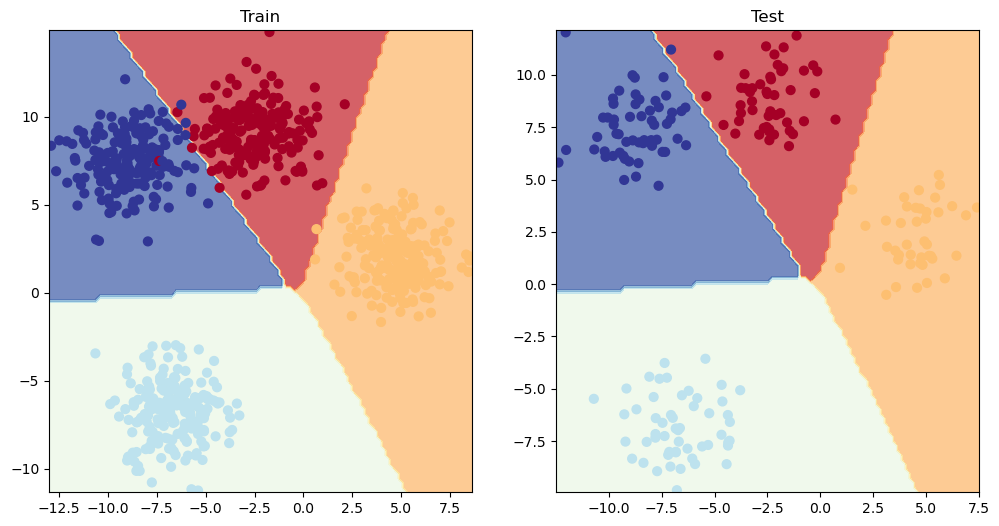

In [24]:
### Visualizing the Model

import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("Helper functions exists. Skipping download")
else:
    print("Downloading Helper Functions ...")
    requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(requests.content)
        

    
from helper_functions import plot_predictions,plot_decision_boundary
print(X_train.shape)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model,X_test,y_test)


In [14]:
"""
torch.manual_seed(47)
m = 12 
c = 3

X = torch.arange(0,100,0.01)
y = m*X+c

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.1)

my_data = pd.DataFrame( {"Input":X_train , "Output":y_train} )

X_train, y_train = X_train.unsqueeze(1) , y_train.unsqueeze(1)

sample_model = nn.Sequential(
    nn.Linear(1,10),
    nn.BatchNorm1d(10),
    nn.Linear(10,10),
    nn.BatchNorm1d(10),
    nn.Linear(10,1)
)

criterion = nn.L1Loss()
optimizer = torch.optim.SGD(sample_model.parameters(),lr=0.1)

for epoch in range(1000):
    
    outputs = sample_model(X_train)
    loss = criterion(outputs,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(epoch%1==0):
        print(f" Epoch {epoch+1} ----- Loss is {loss} Outputs from model shape {y_train.shape}")
    



"""


'\ntorch.manual_seed(47)\nm = 12 \nc = 3\n\nX = torch.arange(0,100,0.01)\ny = m*X+c\n\nX_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.1)\n\nmy_data = pd.DataFrame( {"Input":X_train , "Output":y_train} )\n\nX_train, y_train = X_train.unsqueeze(1) , y_train.unsqueeze(1)\n\nsample_model = nn.Sequential(\n    nn.Linear(1,10),\n    nn.BatchNorm1d(10),\n    nn.Linear(10,10),\n    nn.BatchNorm1d(10),\n    nn.Linear(10,1)\n)\n\ncriterion = nn.L1Loss()\noptimizer = torch.optim.SGD(sample_model.parameters(),lr=0.1)\n\nfor epoch in range(1000):\n    \n    outputs = sample_model(X_train)\n    loss = criterion(outputs,y_train)\n    optimizer.zero_grad()\n    loss.backward()\n    optimizer.step()\n    if(epoch%1==0):\n        print(f" Epoch {epoch+1} ----- Loss is {loss} Outputs from model shape {y_train.shape}")\n    \n\n\n\n'

In [16]:
### A multclass classifcation problem


import torch 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split


## 
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


X_blob , y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES , centers = NUM_CLASSES , cluster_std=1.5 , random_state=RANDOM_SEED)

X_blob , y_blob = torch.from_numpy(X_blob).type(torch.float) , torch.from_numpy(y_blob).type(torch.LongTensor)
X_train , X_test, y_train, y_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)


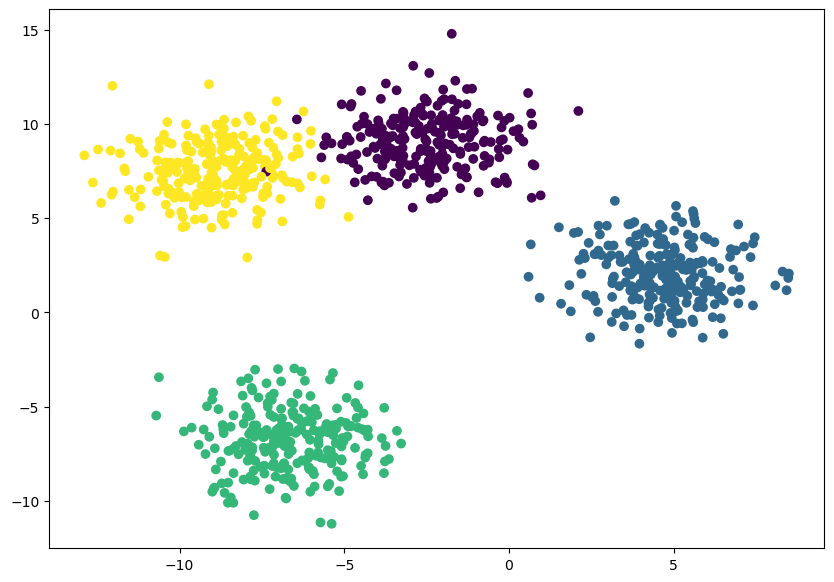

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0] , X_blob[:,1] ,c=y_blob )

In [21]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(2,64),
    nn.ReLU(),
    nn.Linear(64,128),
    nn.ReLU(),
    nn.Linear(128,4),
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)


In [22]:
for epoch in range(1000):
    
    model.train()
    outputs = model(X_train)
    output_probabilites = torch.softmax(outputs,dim=1)
    output_predictions = torch.argmax(output_probabilites,dim=1)
    loss = criterion(outputs,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    model.eval()
    with torch.inference_mode():
        test_outputs = model(X_test)
        test_predictions = torch.softmax(test_outputs,dim=1).argmax(dim=1)
        
        test_loss = criterion(test_outputs,y_test)
        test_accuracy = accuracy_calc(y_true=y_test,y_pred=test_predictions)
        
    
    if(epoch%100==0):
        print(f"Epoch:{epoch} ----> Loss: {test_loss:.5f} , Accuracy: {test_accuracy:.5f}")

Epoch:0 ----> Loss: 1.22508 , Accuracy: 45.50000
Epoch:100 ----> Loss: 0.09141 , Accuracy: 99.50000
Epoch:200 ----> Loss: 0.05155 , Accuracy: 99.50000
Epoch:300 ----> Loss: 0.03802 , Accuracy: 99.50000
Epoch:400 ----> Loss: 0.03133 , Accuracy: 99.50000
Epoch:500 ----> Loss: 0.02733 , Accuracy: 99.50000
Epoch:600 ----> Loss: 0.02469 , Accuracy: 99.50000
Epoch:700 ----> Loss: 0.02279 , Accuracy: 99.50000
Epoch:800 ----> Loss: 0.02137 , Accuracy: 99.50000
Epoch:900 ----> Loss: 0.02027 , Accuracy: 99.50000


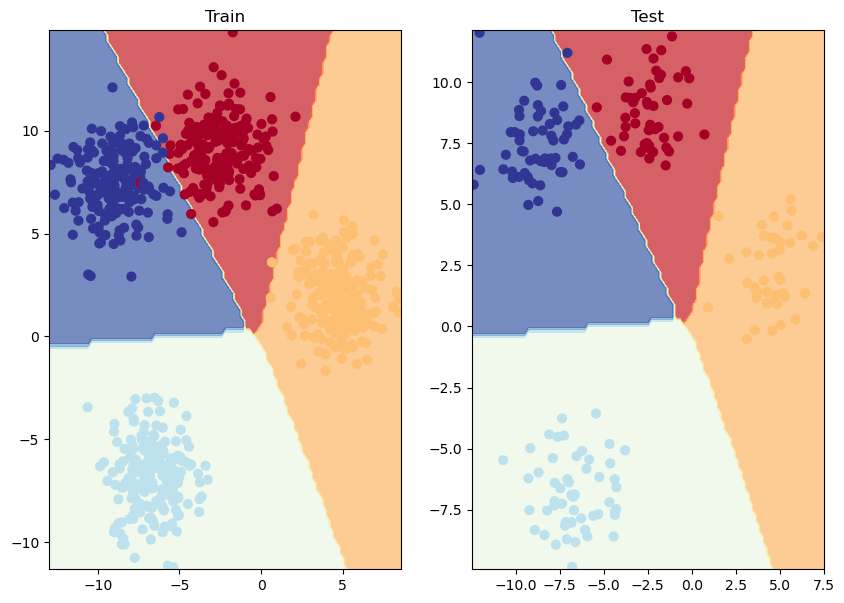

In [25]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model,X_test,y_test)